In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import svm
from sklearn.svm import SVR

# EDA

Each .csv file contains real-time recording data of the battery's Voltage, Current, Temperature, Current Charge, & Voltage Charge during discharge.

In [2]:
testing_record = pd.read_csv('data/00001.csv')
testing_record.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625


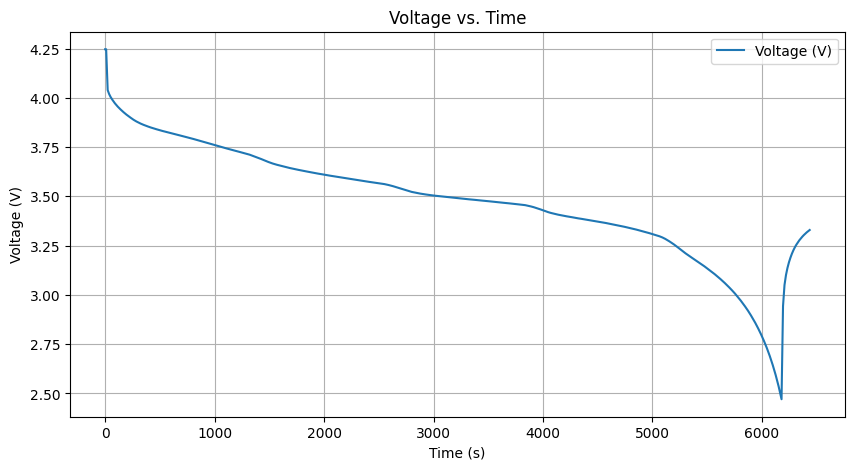

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(testing_record['Time'],testing_record['Voltage_measured'], label='Voltage (V)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage vs. Time')
plt.grid()
plt.show()

The battery voltage decreases over time.

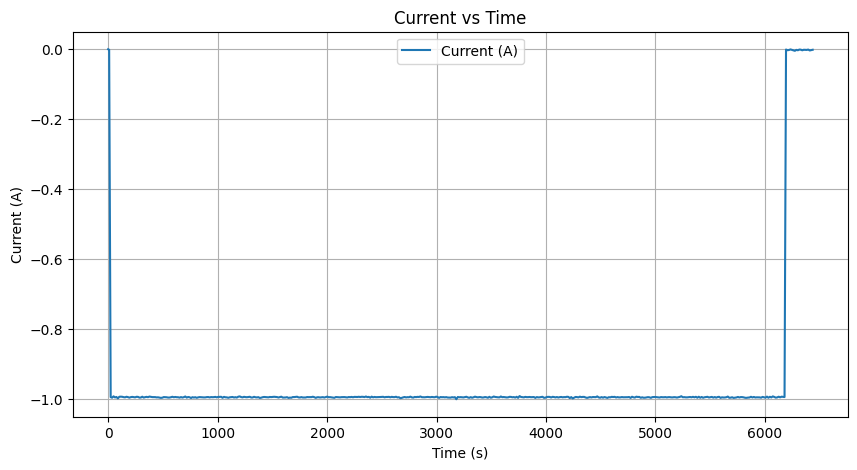

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(testing_record['Time'], testing_record['Current_measured'], label='Current (A)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Current vs Time')
plt.grid()
plt.show()

The current tends to be constant over time.

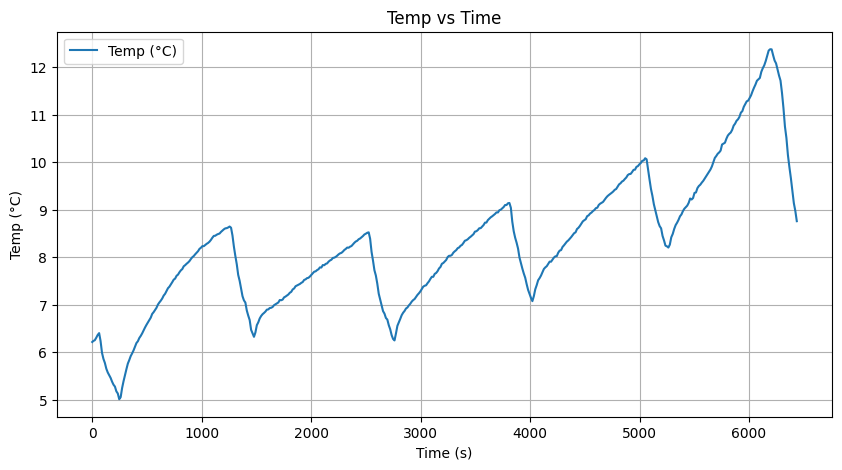

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(testing_record['Time'], testing_record['Temperature_measured'], label='Temp (°C)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temp (°C)')
plt.title('Temp vs Time')
plt.grid()
plt.show()

Over time, the battery temperature increases.

metadata.csv contains details / descriptive information for each battery test data located in the 'data' folder.

In [6]:
metadata = pd.read_csv('metadata.csv')

metadata.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


The metadata allows us to determine which experiments are discharge (battery depletion) experiments based on the battery_id column.

In [7]:
metadata[metadata['type'] == 'discharge']['battery_id']

0       B0047
4       B0047
6       B0047
8       B0047
10      B0047
        ...  
7553    B0055
7555    B0055
7557    B0055
7561    B0055
7563    B0055
Name: battery_id, Length: 2794, dtype: object

# Data Preprocessing

We're only using battery discharge experiment data

In [8]:
discharged_metadata = metadata[ (metadata['type'] == 'discharge')]

In [9]:
discharged_metadata['battery_id'].unique()

array(['B0047', 'B0045', 'B0048', 'B0046', 'B0043', 'B0032', 'B0039',
       'B0040', 'B0029', 'B0028', 'B0042', 'B0034', 'B0038', 'B0033',
       'B0030', 'B0041', 'B0027', 'B0044', 'B0036', 'B0025', 'B0026',
       'B0031', 'B0049', 'B0050', 'B0052', 'B0051', 'B0006', 'B0005',
       'B0007', 'B0018', 'B0053', 'B0054', 'B0056', 'B0055'], dtype=object)

In [10]:
# Assigns a sequential cycle number for each different battery_id
discharged_metadata = discharged_metadata.copy()
discharged_metadata.loc[:, 'cycle_number'] = discharged_metadata.groupby('battery_id').cumcount() + 1

In [11]:
discharged_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2794 entries, 0 to 7563
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   type                 2794 non-null   object
 1   start_time           2794 non-null   object
 2   ambient_temperature  2794 non-null   int64 
 3   battery_id           2794 non-null   object
 4   test_id              2794 non-null   int64 
 5   uid                  2794 non-null   int64 
 6   filename             2794 non-null   object
 7   Capacity             2794 non-null   object
 8   Re                   0 non-null      object
 9   Rct                  0 non-null      object
 10  cycle_number         2794 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 261.9+ KB


In [12]:
# Get all capacities from discharged_metadata and convert them to numeric type
initial_capacities = pd.to_numeric(discharged_metadata['Capacity'], errors='coerce')
initial_capacities.max()

2.6401491157387014

In [13]:
nominal_capacity = initial_capacities.mean()

nominal_capacity = 2.0

print(nominal_capacity)

2.0


In [14]:
# A battery is considered unfit for use when its SoH reaches 80%
degrade_capacity_threshold = nominal_capacity * 80/100 
print(degrade_capacity_threshold)

1.6


- In the next step, we will trim the recorded data where the Voltage is below 2.7 V, as below 2.7 V indicates the battery is about to run out. We will only analyze the battery recording data before it's depleted. This will be done for all CSV files where the experiment type is discharge.

- After obtaining the recording data above 2.7 V, we will calculate the battery Capacity using a formula.

- Through Capacity, we can calculate SoC (State of Charge), and through SoC, we can calculate SoH (State of Health).

- A separate column will be created for each of these calculations in the current iterated dataframe.

In [15]:
processed_dfs = []

In [16]:
for _, row in tqdm(discharged_metadata.iterrows(), total=len(discharged_metadata)):
    
    try:
        file = f"data/{row.filename}"
        df = pd.read_csv(file)

        # Finds the index when the voltage first drops below 2.7 V, because below 2.7 V means the battery is about to run out
        cutoff_idx = df[df['Voltage_measured'] < 2.7].index.min()
        # Takes data only when >= 2.7 V
        cutoff_df = df if pd.isna(cutoff_idx) else df.iloc[:cutoff_idx].copy()
        # Count Time Difference in Hours
        cutoff_df['Time_diff_hr'] = cutoff_df['Time'].diff().fillna(0) / 3600
        # Count Delta Q -> Current Measured x Time Difference in Hours
        cutoff_df['Delta_q'] = cutoff_df['Current_measured'] * cutoff_df['Time_diff_hr']
        # Count total capacity from current df (Ah)
        total_capacity = abs(cutoff_df['Delta_q'].sum())

        # We take data with capacity above the threshold so that we only analyze battery cycles that are still healthy or viable.
        # If the capacity is already below the threshold, it means the battery is too damaged/heavily degraded, and that data is less representative for normal battery health analysis.
        if total_capacity > degrade_capacity_threshold:

            cutoff_df['battery_id'] = row.battery_id
            cutoff_df['cycle_number'] = row.cycle_number
            cutoff_df['cumulative_q'] = cutoff_df['Delta_q'].cumsum()
            cutoff_df['SoC'] = 100 * (1 + (cutoff_df['cumulative_q'] / total_capacity))

            if cutoff_df['SoC'].min() < 0 or cutoff_df['SoC'].max() > 100:
                continue
            else :
                soh = (total_capacity / nominal_capacity) * 100
                if soh > 100:
                    continue
                else:
                    cutoff_df['SoH'] = soh 
                    num_bins = 20
                    # Downsampling divides the data into num_bins groups, with each group containing an average of len(cutoff_df) / num_bins elements
                    # Downsampling is done to improve computational efficiency
                    bins = np.array_split(cutoff_df, num_bins)
                    agg_rows = []
                    for b in bins:
                        if b.empty:
                            continue 
                        avg_voltage = b['Voltage_measured'].mean()
                        avg_current = b['Current_measured'].mean()
                        avg_temp = b['Temperature_measured'].mean()
                        avg_soc = b['SoC'].mean()                
                        agg_rows.append({
                            'Voltage_measured': avg_voltage,
                            'Current_measured': avg_current,
                            'Temperature_measured': avg_temp,
                            'SoC': avg_soc,
                            'cycle_number': b['cycle_number'].iloc[0],
                            'battery_id': b['battery_id'].iloc[0],
                            'SoH': b['SoH'].iloc[0]
                        })
                    downsampled_df = pd.DataFrame(agg_rows)
                    if len(downsampled_df) != num_bins:
                        continue
                    processed_dfs.append(downsampled_df)

    except Exception as e:
        print(f"Error processing {row['filename']}: {str(e)}")


  5%|▍         | 139/2794 [00:02<01:00, 44.03it/s]C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  8%|▊         | 214/2794 [00:04<00:49, 52.38it/s]C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
 10%|█         | 288/2794 [00:05<00:54, 45.78it/s]C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\numpy\core\

In [17]:
full_dataset = []

# Combine all processed data
if processed_dfs:
    full_dataset = pd.concat(processed_dfs)
    print(f"Final dataset shape: {full_dataset.shape}")
    full_dataset.to_csv("battery_health_dataset.csv", index=False)
else:
    print("No valid files found!")

Final dataset shape: (7580, 7)


In [18]:
# Separate features and target variable
X = full_dataset[[
    'Voltage_measured', 
    'Current_measured', 
    'Temperature_measured',
    'SoC', 
    'cycle_number'
]]
y = full_dataset['SoH']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale train and test sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training and Evaluation

### Random Forest Model

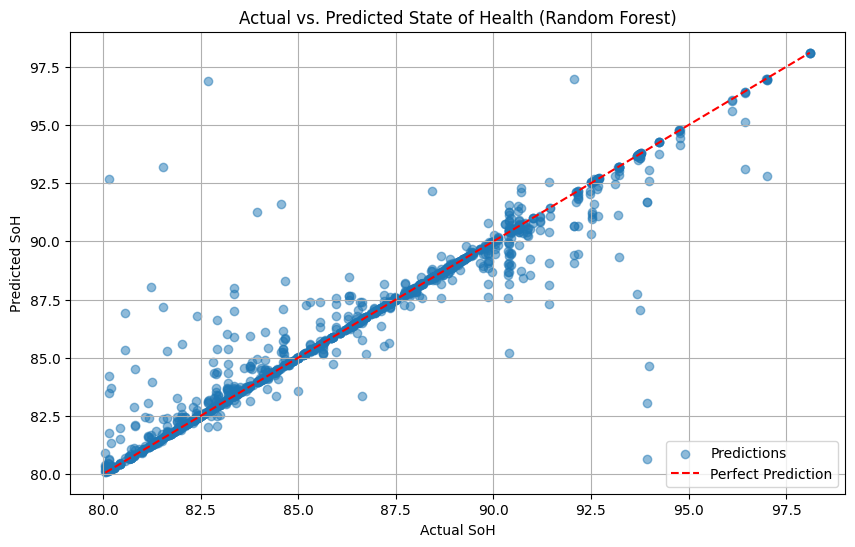

Random Forest Results:
Mean Absolute Error (MAE): 0.32
Root Mean Squared Error (RMSE): 1.11
R² Score: 0.92


In [19]:
# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict test set
y_pred = model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title('Actual vs. Predicted State of Health (Random Forest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print metrics
print(f"Random Forest Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

In [20]:
import time
import numpy as np

# warm-up
_ = model.predict(X_test[:1])

times = []
for i in range(1000):
    start = time.time()
    _ = model.predict(X_test[:1])
    times.append((time.time() - start) * 1000)  # ms

print(f"Median inference time: {np.median(times):.4f} ms")
print(f"99th percentile inference time: {np.percentile(times, 99):.4f} ms")

Median inference time: 2.5709 ms
99th percentile inference time: 3.7958 ms


### XGBoost Model

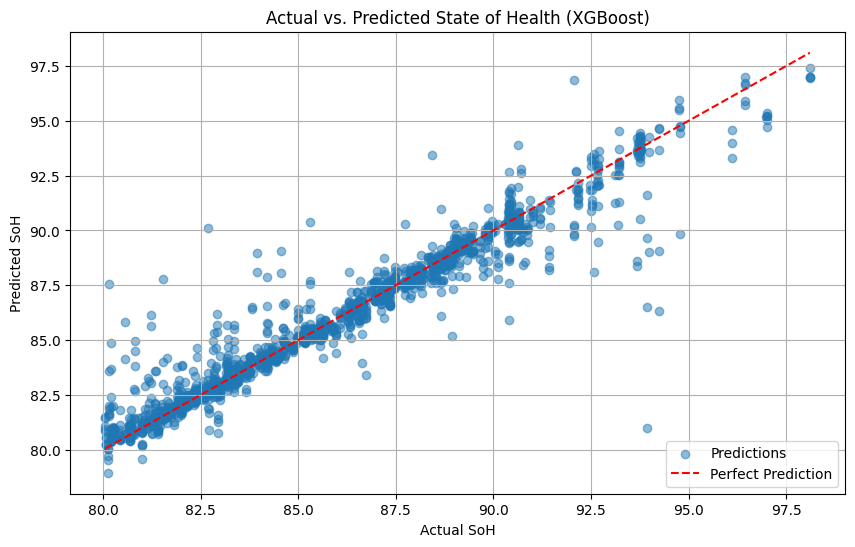

XGBoost Results:
Mean Absolute Error (MAE): 0.56
Root Mean Squared Error (RMSE): 1.06
R² Score: 0.92


In [22]:
# Train model
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title('Actual vs. Predicted State of Health (XGBoost)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print metrics
print(f"XGBoost Results:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.2f}")

In [23]:
import time
import numpy as np

# warm-up
_ = model.predict(X_test[:1])

times = []
for i in range(1000):
    start = time.time()
    _ = model.predict(X_test[:1])
    times.append((time.time() - start) * 1000)  # ms

print(f"Median inference time: {np.median(times):.4f} ms")
print(f"99th percentile inference time: {np.percentile(times, 99):.4f} ms")

Median inference time: 3.0111 ms
99th percentile inference time: 4.0522 ms


### SVM Model

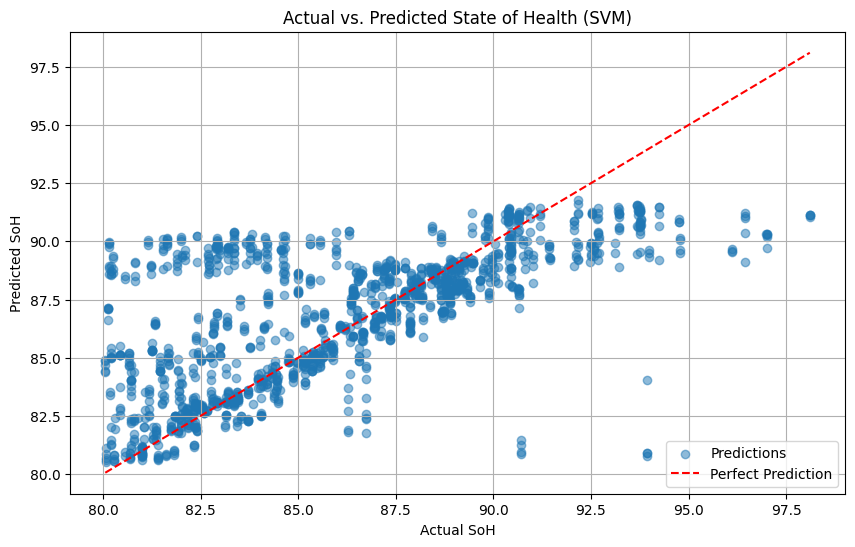

SVM Results:
Mean Absolute Error (MAE): 1.95
Root Mean Squared Error (RMSE): 2.96
R² Score: 0.40


In [24]:
# Train model
model_svm = svm.SVR() 
model_svm.fit(X_train, y_train)

# Predict test set
y_pred_svm = model_svm.predict(X_test)

# Evaluate model
mae_svm = mean_absolute_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
r2_svm = r2_score(y_test, y_pred_svm)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svm, alpha=0.5, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title('Actual vs. Predicted State of Health (SVM)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print metrics
print(f"SVM Results:")
print(f"Mean Absolute Error (MAE): {mae_svm:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_svm:.2f}")
print(f"R² Score: {r2_svm:.2f}")


In [25]:
import time
import numpy as np

# warm-up
_ = model.predict(X_test[:1])

times = []
for i in range(1000):
    start = time.time()
    _ = model.predict(X_test[:1])
    times.append((time.time() - start) * 1000)  # ms

print(f"Median inference time: {np.median(times):.4f} ms")
print(f"99th percentile inference time: {np.percentile(times, 99):.4f} ms")

Median inference time: 2.7125 ms
99th percentile inference time: 4.1175 ms


### Tuned SVM Model

Fitting 5 folds for each of 60 candidates, totalling 300 fits


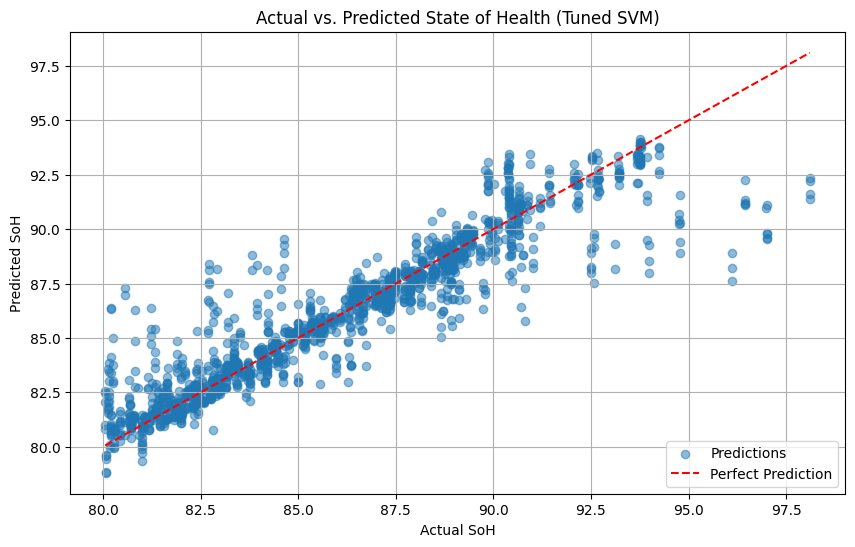

Tuned SVM Results:
Best Parameters: {'C': 100, 'epsilon': 0.5, 'gamma': 1}
Mean Absolute Error (MAE): 0.88
Root Mean Squared Error (RMSE): 1.46
R² Score: 0.85


In [26]:
# Set up GridSearchCV and train model
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predict test set
y_pred = best_model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title('Actual vs. Predicted State of Health (Tuned SVM)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print metrics
print(f"Tuned SVM Results:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

In [27]:
import time
import numpy as np

# warm-up
_ = model.predict(X_test[:1])

times = []
for i in range(1000):
    start = time.time()
    _ = model.predict(X_test[:1])
    times.append((time.time() - start) * 1000)  # ms

print(f"Median inference time: {np.median(times):.4f} ms")
print(f"99th percentile inference time: {np.percentile(times, 99):.4f} ms")

Median inference time: 3.0599 ms
99th percentile inference time: 4.6807 ms
